In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
#defining the constant to use/refer in the later part

In [69]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 80

In [4]:
#loading data into tf.Dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
    

Found 4500 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names


['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [7]:
#data visulisation of 16 images from the 1st batch of dataset

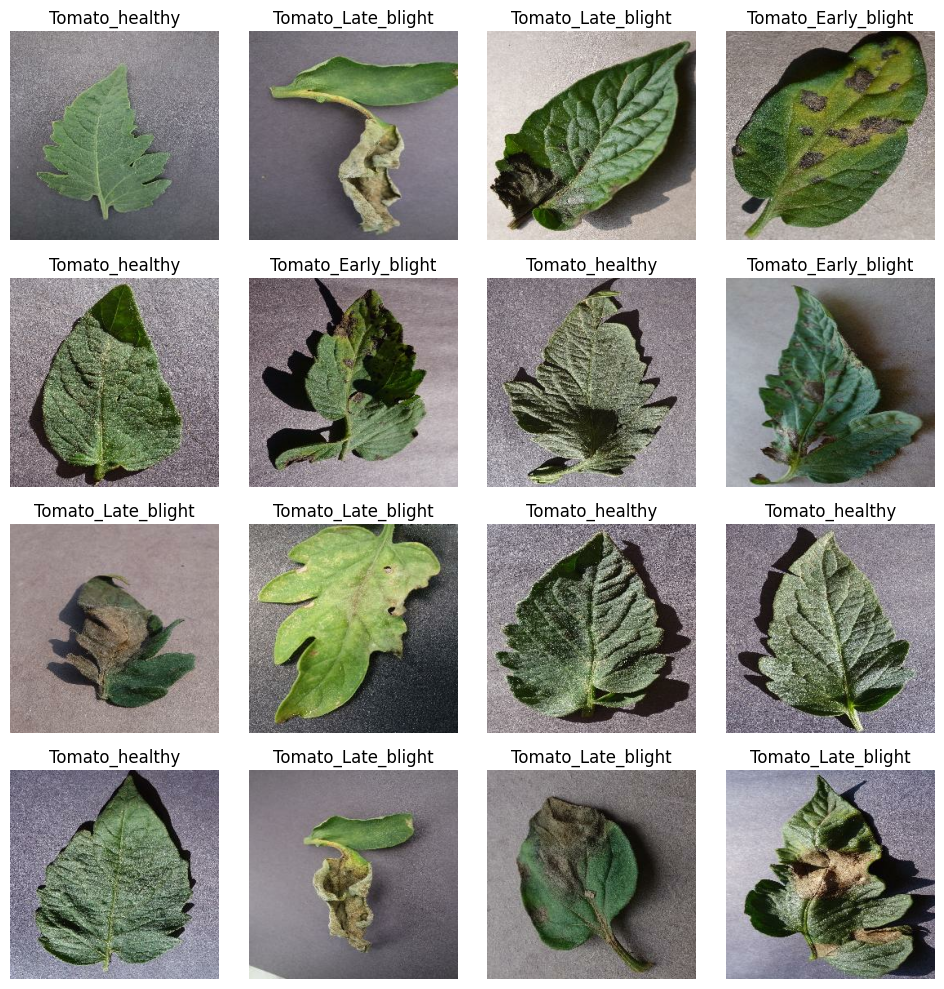

In [8]:
plt.figure(figsize=(10,10)) #changing size of image so they are evenly spaced
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1) #adjust the num of rows and columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.tight_layout() # Adjust subplot parameters to avoid overlap
    

In [9]:
# train, test and split

In [10]:
len(dataset)

141

In [11]:
train_size = 0.8 #80% is the train size
len(dataset)*train_size #get the total batch for the training

112.80000000000001

In [12]:
train_ds = dataset.take(112) #take 112 from the dataset
len(train_ds)

112

In [13]:
rem_ds = dataset.skip(112) #since train is 112, skip that and put in remaining dataset
len(rem_ds)

29

In [14]:
val_size = 0.1 #validation size is 10%
len(dataset)*val_size #get the validation size

14.100000000000001

In [15]:
val_ds = rem_ds.take(14) #take 14 batch from remaining dataset(rem_ds)
len(val_ds)

14

In [16]:
test_ds = rem_ds.skip(14) #for test dataset (test_ds), skip 14 from rem_ds
len(test_ds)

15

In [17]:
#function for spliting dataset

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

112

In [21]:
len(val_ds)

14

In [22]:
len(test_ds)

15

In [23]:
#Cache, Shuffle, Prefetch for the optimisation of dataset for doing the training fast

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#Layer needed for normalisation and resizing OR for preprocessing later

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
#data augmentation for preprocessing

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
#Using data augmentation for dataset (Train-dataset)

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [32]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=80,
)

Epoch 1/80


112/112 [==============================] - 83s 609ms/step - loss: 1.0301 - accuracy: 0.4555 - val_loss: 0.9802 - val_accuracy: 0.4219
Epoch 2/80
112/112 [==============================] - 60s 531ms/step - loss: 0.8643 - accuracy: 0.5647 - val_loss: 0.7825 - val_accuracy: 0.6585
Epoch 3/80
112/112 [==============================] - 58s 518ms/step - loss: 0.5429 - accuracy: 0.7643 - val_loss: 0.7152 - val_accuracy: 0.7210
Epoch 4/80
112/112 [==============================] - 62s 544ms/step - loss: 0.4016 - accuracy: 0.8270 - val_loss: 1.0382 - val_accuracy: 0.6228
Epoch 5/80
112/112 [==============================] - 56s 499ms/step - loss: 0.3848 - accuracy: 0.8312 - val_loss: 0.7766 - val_accuracy: 0.7946
Epoch 6/80
112/112 [==============================] - 56s 498ms/step - loss: 0.2937 - accuracy: 0.8726 - val_loss: 0.3913 - val_accuracy: 0.8638
Epoch 7/80
112/112 [==============================] - 54s 485ms/step - loss: 0.2620 - accuracy: 0.8931 - val_loss: 0.4457 - val_

In [50]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 11s 601ms/step - loss: 0.0419 - accuracy: 0.9875


In [36]:
#The accuracy is pretty promising with 0.98% for the test dataset

In [52]:
scores

[0.04185991361737251, 0.987500011920929]

In [ ]:
#scores is just loss and accuracy

In [ ]:
#⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇ PLOTTING THE ACCURACY AND LOSS CURVES ⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇

In [53]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 112}

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [56]:
type(history.history['loss'])

list

In [57]:
len(history.history['loss'])

80

In [58]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0300694704055786,
 0.8643354177474976,
 0.5428603291511536,
 0.40160712599754333,
 0.38477233052253723]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

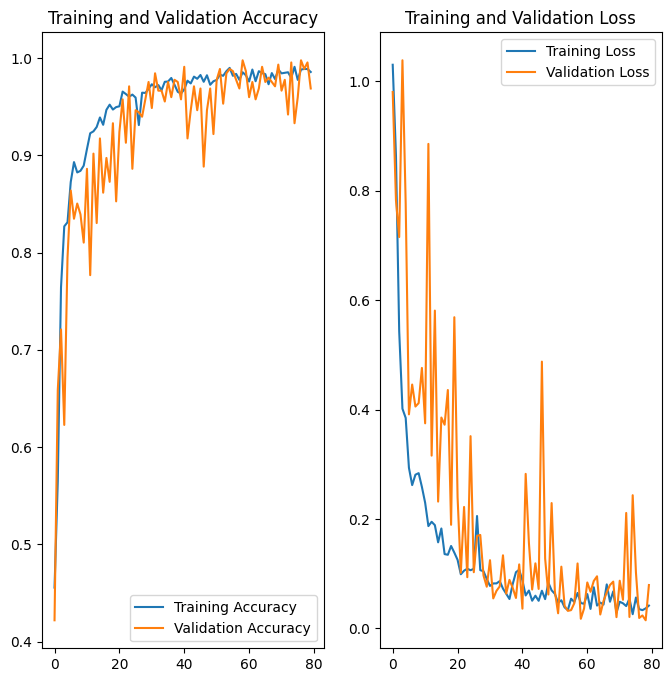

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#RUN PREDICTION ON A SAMPLE IMAGE

first image to predict
actual label: Tomato_Early_blight
1/1 [==============================] - 1s 687ms/step
predicted label: Tomato_Early_blight


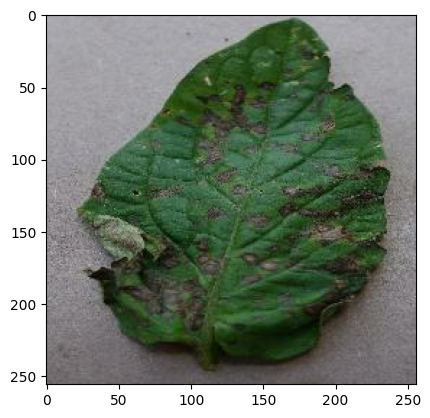

In [73]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
#WRITE FUNCTION FOR INFERENCE


In [74]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
#Now run inference on few sample images

1/1 [==============================] - 0s 82ms/step


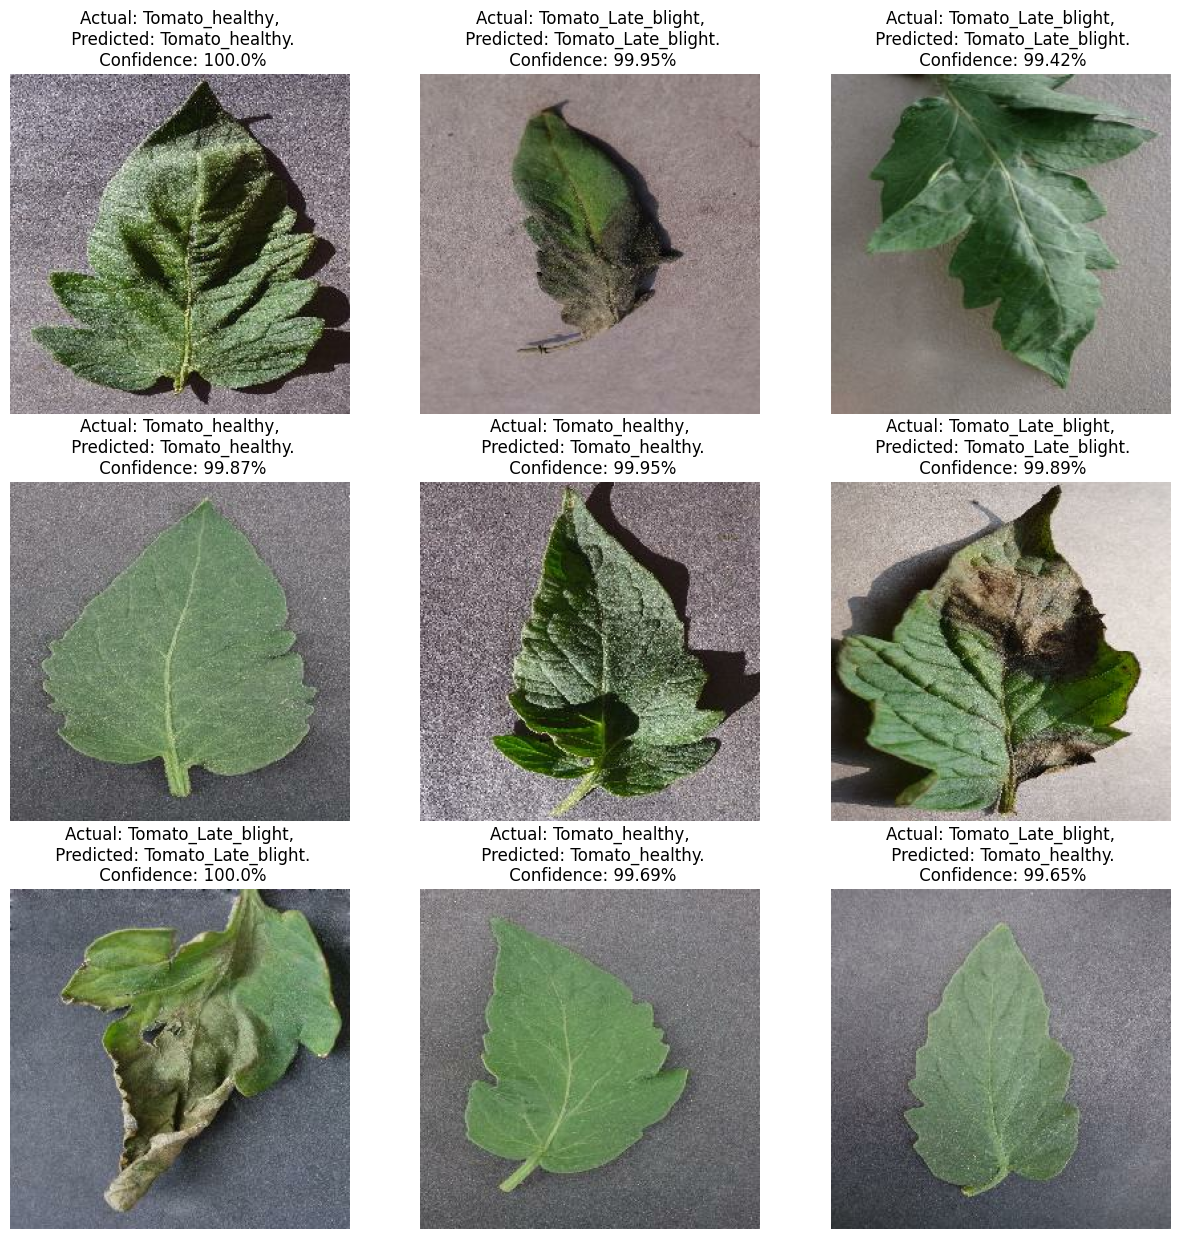

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
#SAVING THE MODEL

In [86]:
import os                                                                              #saves the model in the auto increment
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets
